In [160]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from prospect.models import priors, transforms, templates
import pandas as pd

In [186]:
sigma=0.3
df=2
nbins = 11
tuniv = 13.7
tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = np.log10(3e7), np.log10(1e8)
#agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T
agelims = np.linspace(0, tuniv, nbins)

nbins_sfh = len(agelims) - 1
cont_prior = priors.StudentT(mean=np.full(nbins_sfh-1,0.0),scale=np.full(nbins_sfh-1,sigma),df=np.full(nbins_sfh-1,df))
cont_mprior = priors.LogUniform(mini=1e8, maxi=1e12)

alpha_sfh = 0.7 # desired Dirichlet concentration                                                       
ncomp = nbins_sfh          # number of SFH bins                                                          
alpha = np.repeat(alpha_sfh,ncomp-1)
tilde_alpha = np.array([alpha[i-1:].sum() for i in range(1,ncomp)])
dir_prior = priors.Beta(alpha=tilde_alpha, beta=alpha, mini=0.01, maxi=0.999)


tau_prior = priors.LogUniform(mini=0.1, maxi=30)
tage_prior = priors.TopHat(mini=0.001, maxi=tuniv)
start_prior = priors.TopHat(mini=0.001, maxi=tuniv-0.1)


ndraw = 500000

In [3]:
sfr_ratio = np.zeros((ndraw, nbins_sfh-1))
for i in range(ndraw):
    sfr_ratio[i] = cont_prior.sample()

In [4]:
logmass = np.zeros(ndraw)
for i in range(ndraw):
    logmass[i] = cont_mprior.sample()

In [5]:
zfrac = np.zeros((ndraw, nbins_sfh-1))
for i in range(ndraw):
    zfrac[i] = dir_prior.sample()

In [145]:
zfrac = dir_prior.sample()
mass = cont_mprior.sample()
tau = tau_prior.sample()
tage = tuniv
sfr_start = 0+0.01

In [146]:
dir_sfr = transforms.zfrac_to_sfr(mass, zfrac, agebins)

In [147]:
times = np.linspace(0, tuniv, 1000)

In [154]:
mfrac_burst = priors.TopHat(mini=0.0, maxi=0.5).sample()
mfrac_else = 1.0 - mfrac_burst
fage_burst = priors.TopHat(mini=0.6, maxi=1.0).sample()
tburst = transforms.tburst_from_fage(tage, fage_burst)
norm_tau = (mfrac_else * mass) / (tage * 1.0e9)
bsfr = []
for i in times:
    if i < sfr_start:
        bsfr.append(0)
    else:
        bsfr.append(norm_tau * (i - sfr_start) * np.exp(-(i-sfr_start) / 1))
time = np.append(times, tburst[0])
time.sort()
idx = np.where(time == tburst[0])[0][0]
norm_burst = (mfrac_burst[0] * mass) / (1e8)
burst = np.insert(bsfr, idx, norm_burst)


In [157]:
exp_dec = []
delay_exp = []
const = []
for i in times:
    if i < sfr_start:
        exp_dec.append(0)
        delay_exp.append(0)
        const.append(mass/(tage*1e9))
    else:
        exp_dec.append((mass/(tage*1e9)) * np.exp((i - sfr_start) / -1))
        delay_exp.append((mass/(tage*1e9)) * (i - sfr_start) * np.exp((i - sfr_start)/-1))
        const.append(mass/(tage*1e9))

In [221]:
mufasa_sfh = pd.read_csv('/Volumes/SML/UF/cosmo_sim_halos/mufasa_zooms/sfh/sfh_halo401.csv')

In [222]:
msfr = mufasa_sfh['SFR_401 [Msol/yr]']
mtime = mufasa_sfh['Time [Myr]']
m_time = [x/1e3 for x in mtime]

In [227]:
nonpara = [0, 0.25,  0.35,  0.2, 0.18, 0.23, 0.5, 0.35, 0.8,  0.55]

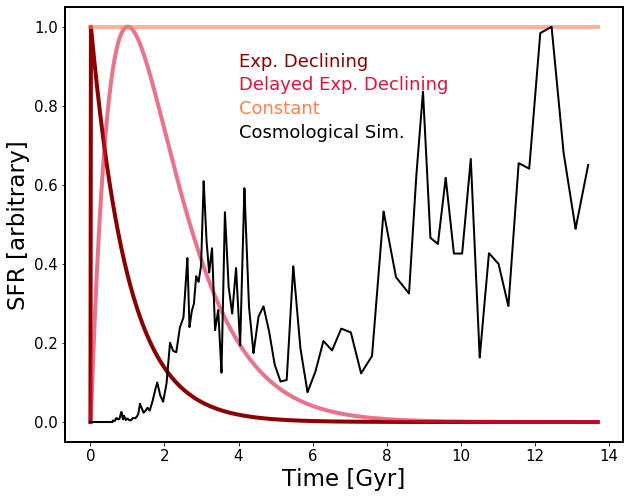

In [236]:
plt.figure(figsize=(10, 8))
plt.rc('axes', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
plt.plot(times, exp_dec/np.max(exp_dec), color='darkred', lw=4)
plt.plot(times, delay_exp/np.max(delay_exp), color='crimson', lw=4, alpha=0.6)
plt.plot(times, const/np.max(const), color='coral', lw=4, alpha=0.6)
plt.plot(m_time, msfr/np.max(msfr), color='black', lw=2)
#for i in range(len(nonpara)):
#    plt.plot([agelims[i], agelims[i+1]], [nonpara[i], nonpara[i]], color='darkorange', lw=5)
plt.ylabel('SFR [arbitrary]', fontsize=23)
plt.xlabel('Time [Gyr]', fontsize=23)
plt.annotate(r'Exp. Declining', xy=(4, 0.9), color='darkred', fontsize=18)
plt.annotate(r'Delayed Exp. Declining', xy=(4, 0.84), color='crimson', fontsize=18)
plt.annotate(r'Constant', xy=(4, 0.78), color='coral', fontsize=18)
plt.annotate(r'Cosmological Sim.', xy=(4, 0.72), color='black', fontsize=18)
#plt.annotate(r'Nonparametric', xy=(4, 0.66), color='darkorange', fontsize=18)
plt.savefig('/Users/sidneylower/Documents/prosp_final_plots/sfh_example_zoom.png', dpi=300, bbox_inches='tight')

In [11]:
cont_masses = []
for i in range(ndraw):
    cont_masses.append(transforms.logsfr_ratios_to_masses(mm_sample[0][i], sfr_ratio[i], agebins))

In [12]:
dir_masses = []
for i in range(ndraw):
    dir_masses.append(transforms.zfrac_to_masses(10**mm_sample[0][i], zfrac[i], agebins))

In [13]:
dir_sfr = []
cont_sfr = []
for i in range(ndraw):
    dir_sfr.append(transforms.zfrac_to_sfr(10**mm_sample[0][i], zfrac[i], agebins))
    cont_sfr.append(transforms.logsfr_ratios_to_sfrs(mm_sample[0][i], sfr_ratio[i], agebins))

In [14]:
contsfr_30 = [t[0] for t in cont_sfr]
contsfr_100 = [t[1] for t in cont_sfr]
contsfr_comb = np.array([contsfr_30, contsfr_100])
contsfr_100ave = np.average(contsfr_comb, axis=0)

In [15]:
dirsfr_30 = [t[0] for t in dir_sfr]
dirsfr_100 = [t[1] for t in dir_sfr]
dirsfr_comb = np.array([dirsfr_30, dirsfr_100])
dirsfr_100ave = np.average(dirsfr_comb, axis=0)

In [16]:
sSFR_cont = np.asarray(contsfr_100ave) / np.asarray((10**mm_sample[0])*0.8)
sSFR_dir = np.asarray(dirsfr_100ave) / np.asarray((10**mm_sample[0])*0.8)

In [17]:
def nonpara_massweighted_age(mass_in_each_bin, time, total_mass):
    top = 0.0
    time = (10**time) / 1e9
    #print(time)
    for bin_ in range(len(mass_in_each_bin)):
        top += 0.5 * np.abs(time[bin_] + time[bin_+1]) * mass_in_each_bin[bin_]
        #print(top)
    return top / (total_mass)

In [18]:
age_cont = []
for i in range(ndraw):
    age_cont.append(nonpara_massweighted_age(mass_in_each_bin=cont_masses[i], time=np.unique(np.ravel(agebins)), total_mass=10**mm_sample[0][i]))
    
    

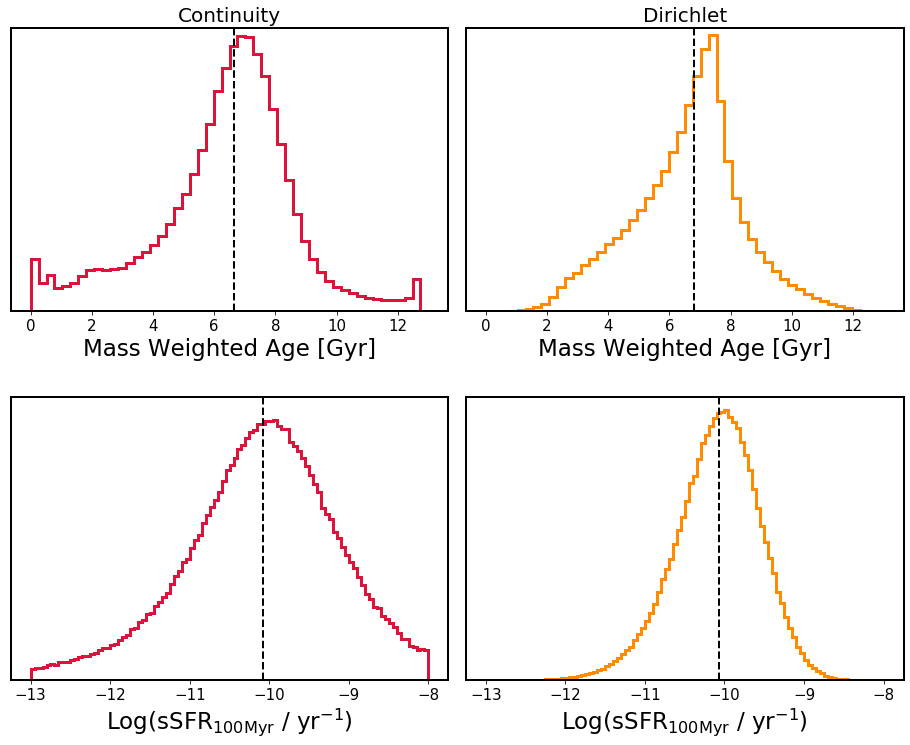

In [28]:
plt.rc('axes', linewidth=2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(wspace=0.04, hspace=0.3)



for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor')
    ax.set_xlabel('Mass Weighted Age [Gyr]', fontsize=23)
    ax.get_yaxis().set_ticks([])
for ax in (ax3, ax4):
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor')
    ax.set_xlabel('Log(sSFR$_{100 \mathrm{Myr}}$ / yr$^{-1}$)', fontsize=23)
    ax.get_yaxis().set_ticks([])

nc, bins, _ = ax1.hist(age_cont, bins=50, range=(0, 13), histtype='step', color='crimson', lw=3)
nb, bins, _ = ax2.hist(age_dir, bins=50, range=(0, 13), histtype='step', color='darkorange', lw=3)
ax1.plot([np.median(age_cont), np.median(age_cont)], [0, 1e5], color='black', ls='--', lw=2)
ax2.plot([np.median(age_dir), np.median(age_dir)], [0, 1e5], color='black', ls='--', lw=2)
nc1, bins, _ = ax3.hist(np.log10(sSFR_cont), bins=100, range=(-13, -8), histtype='step', color='crimson', lw=3)
nb1, bins, _ = ax4.hist(np.log10(sSFR_dir), bins=100, range=(-13, -8), histtype='step', color='darkorange', lw=3)
ax3.plot([np.median(np.log10(sSFR_cont)), np.median(np.log10(sSFR_cont))], [0, 1e5], color='black', ls='--', lw=2)
ax4.plot([np.median(np.log10(sSFR_dir)), np.median(np.log10(sSFR_dir))], [0, 1e5], color='black', ls='--', lw=2)


ax1.set_ylim([0, np.max(nc)+1000])
ax2.set_ylim([0, np.max(nb)+1000])
ax3.set_ylim([0, np.max(nc1)+1000])
ax4.set_ylim([0, np.max(nb1)+1000])
ax1.set_title('Continuity', fontsize=20)
ax2.set_title('Dirichlet', fontsize=20)

plt.savefig('/Users/sidneylower/Documents/prosp_final_plots/nonpara_priors.png', dpi=300, bbox_inches='tight')

In [19]:
age_dir = []
for i in range(ndraw):
    age_dir.append(nonpara_massweighted_age(dir_masses[i], time=np.unique(np.ravel(agebins)), total_mass=10**mm_sample[0][i]))
    

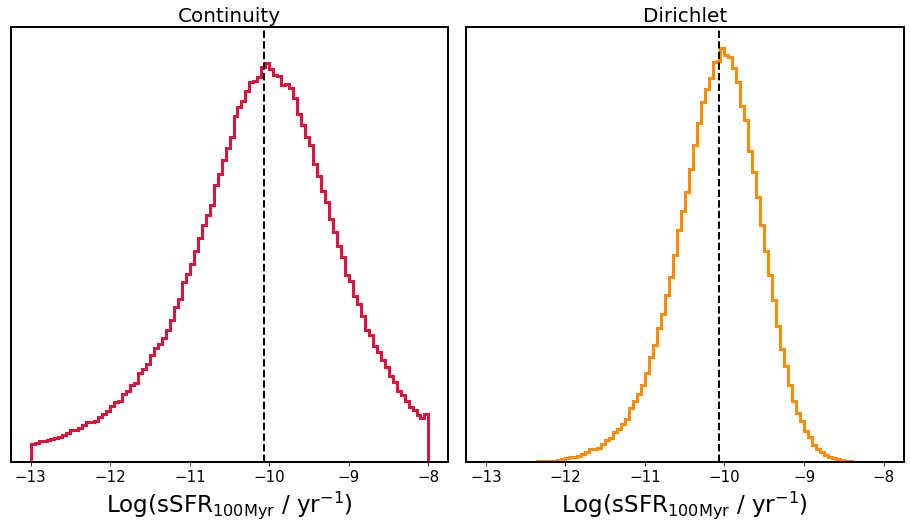

In [886]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0.04, hspace=0.05)



for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor')
    ax.set_xlabel('Log(sSFR$_{100 \mathrm{Myr}}$ / yr$^{-1}$)', fontsize=23)
    ax.get_yaxis().set_ticks([])

nc, bins, _ = ax1.hist(np.log10(sSFR_cont), bins=100, range=(-13, -8), histtype='step', color='crimson', lw=3)
nb, bins, _ = ax2.hist(np.log10(sSFR_dir), bins=100, range=(-13, -8), histtype='step', color='darkorange', lw=3)
ax1.plot([np.median(np.log10(sSFR_cont)), np.median(np.log10(sSFR_cont))], [0, 1e5], color='black', ls='--', lw=2)
ax2.plot([np.median(np.log10(sSFR_dir)), np.median(np.log10(sSFR_dir))], [0, 1e5], color='black', ls='--', lw=2)

ax1.set_ylim([0, np.max(nc)+1000])
ax2.set_ylim([0, np.max(nb)+1000])
ax1.set_title('Continuity', fontsize=20)
ax2.set_title('Dirichlet', fontsize=20)

plt.savefig('/Users/sidneylower/Documents/prosp_final_plots/ssfr_prior.png', dpi=300, bbox_inches='tight')

In [8]:
class MassMet(priors.Prior):
    """A Gaussian prior designed to approximate the Gallazzi et al. 2005 
    stellar mass--stellar metallicity relationship.
    """
    from scipy.stats import truncnorm
    prior_params = ['mass_mini', 'mass_maxi', 'z_mini', 'z_maxi']
    distribution = truncnorm
    massmet = np.loadtxt('/Volumes/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/snap305_massmetal/gallazzi_05_massm\
et.txt')

    def __len__(self):
        """ Hack to work with Prospector 0.3
        """
        return 2

    def scale(self,mass):
        upper_84 = np.interp(mass, self.massmet[:,0], self.massmet[:,3]) 
        lower_16 = np.interp(mass, self.massmet[:,0], self.massmet[:,2])
        return (upper_84-lower_16)

    def loc(self,mass):
        return np.interp(mass, self.massmet[:,0], self.massmet[:,1])

    def get_args(self,mass):
        a = (self.params['z_mini'] - self.loc(mass)) / self.scale(mass)
        b = (self.params['z_maxi'] - self.loc(mass)) / self.scale(mass)
        return [a, b]

    @property
    def range(self):
        return ((self.params['mass_mini'], self.params['mass_maxi']),\
                (self.params['z_mini'], self.params['z_maxi']))

    def bounds(self, **kwargs):
        if len(kwargs) > 0:
            self.update(**kwargs)
        return self.range

    def __call__(self, x, **kwargs):
        """Compute the value of the probability density function at x and
        return the ln of that.
        :params x:
            x[0] = mass, x[1] = metallicity. Used to calculate the prior
        :param kwargs: optional
            All extra keyword arguments are used to update the `prior_params`.
        :returns lnp:
            The natural log of the prior probability at x, scalar or ndarray of
            same length as the prior object.
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        p = np.atleast_2d(np.zeros_like(x))
        a, b = self.get_args(x[...,0])
        p[...,1] = self.distribution.pdf(x[...,1], a, b, loc=self.loc(x[...,0]), scale=self.scale(x[...,0]))
        with np.errstate(invalid='ignore'):
            p[...,1] = np.log(p[...,1])
        return p

    def sample(self, nsample=None, **kwargs):
        """Draw a sample from the prior distribution.
        :param nsample: (optional)
            Unused
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        mass = np.random.uniform(low=self.params['mass_mini'],high=self.params['mass_maxi'],size=nsample)
        a, b = self.get_args(mass)
        met = self.distribution.rvs(a, b, loc=self.loc(mass), scale=self.scale(mass), size=nsample)

        return np.array([mass, met])

    def unit_transform(self, x, **kwargs):
        """Go from a value of the CDF (between 0 and 1) to the corresponding
        parameter value.
        :param x:
            A scalar or vector of same length as the Prior with values between
            zero and one corresponding to the value of the CDF.
        :returns theta:
            The parameter value corresponding to the value of the CDF given by
            `x`.
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        mass = x[0]*(self.params['mass_maxi'] - self.params['mass_mini']) + self.params['mass_mini']
        a, b = self.get_args(mass)
        met = self.distribution.ppf(x[1], a, b, loc=self.loc(mass), scale=self.scale(mass))
        return np.array([mass,met])

In [9]:
massmet_prior = MassMet(z_mini=-1.98, z_maxi=0.19, mass_mini=7, mass_maxi=13)

In [10]:
mm_sample = massmet_prior.sample(nsample=ndraw)

In [909]:
met = mm_sample[1]

In [910]:
dust2 = np.zeros(ndraw)
dust1_frac = np.zeros(ndraw)
uvb = np.zeros(ndraw)
dust_index = np.zeros(ndraw)
for i in range(ndraw):
    dust2[i] = priors.ClippedNormal(mini=0.0, maxi=4.0, mean=0.3, sigma=1).sample()
    dust1_frac[i] = priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3).sample()
    uvb[i] = priors.TopHat(mini=0.0, maxi=4.0).sample()
    dust_index[i] = priors.TopHat(mini=-1.0, maxi=0.4).sample()

In [911]:
dust_gamma = np.zeros(ndraw)
dust_umin = np.zeros(ndraw)
dust_qpah = np.zeros(ndraw)
for i in range(ndraw):
    dust_gamma[i] = priors.TopHat(mini=0.0, maxi=1.0).sample()
    dust_umin[i] = priors.TopHat(mini=0.1, maxi=25.0).sample()
    dust_qpah[i] = priors.TopHat(mini=0.0, maxi=7.0).sample()

In [954]:
dust1 = dust1_frac * dust2

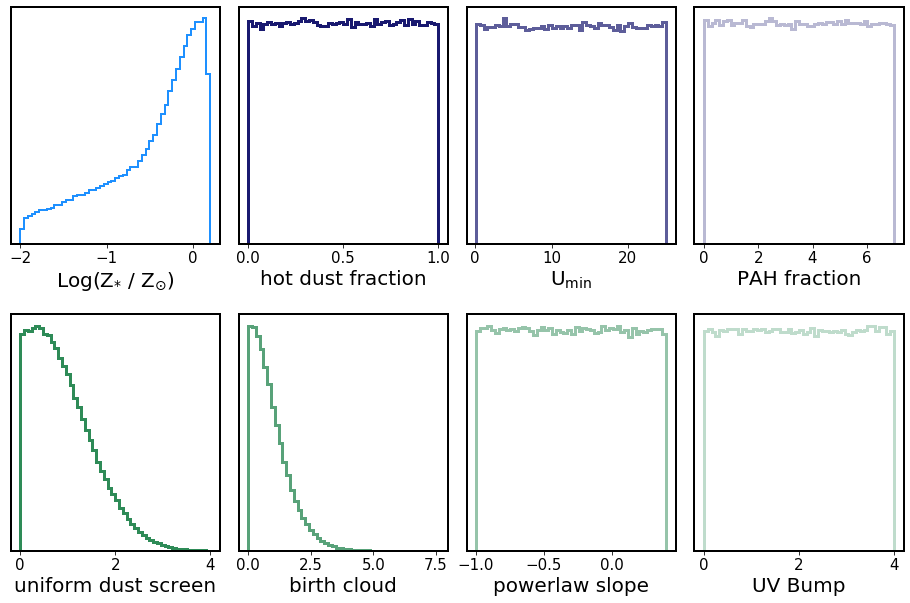

In [965]:
plt.rc('axes', linewidth=2)

ncols = 4
nrows = 2

# create the plots
fig = plt.figure(figsize=(16, 10))
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

plt.subplots_adjust(wspace=0.09, hspace=0.3)


axes[0].hist(met, bins=50, range=(-2, 0.2), lw=2, histtype='step', color='dodgerblue')
axes[0].set_xlabel('Log(Z$_{*}$ / Z$_{\odot}$)', fontsize=20)

axes[1].hist(dust_gamma, bins=50, histtype='step', lw=3, color='midnightblue')
axes[1].set_xlabel('hot dust fraction', fontsize=20)
axes[2].hist(dust_umin, bins=50, histtype='step', lw=3, color='midnightblue', alpha=0.7)
axes[2].set_xlabel('U$_{\mathrm{min}}$', fontsize=20)
axes[3].hist(dust_qpah, bins=50, histtype='step', lw=3, color='midnightblue', alpha=0.3)
axes[3].set_xlabel('PAH fraction', fontsize=20)

axes[4].hist(dust2, bins=50, histtype='step', lw=3, color='seagreen')
axes[4].set_xlabel('uniform dust screen', fontsize=20)
axes[5].hist(dust1, bins=50, histtype='step', lw=3, color='seagreen', alpha=0.8)
axes[5].set_xlabel('birth cloud', fontsize=20)
axes[6].hist(dust_index, bins=50, histtype='step', lw=3, color='seagreen', alpha=0.5)
axes[6].set_xlabel('powerlaw slope', fontsize=20)
axes[7].hist(uvb, bins=50, histtype='step', lw=3, color='seagreen', alpha=0.3)
axes[7].set_xlabel('UV Bump', fontsize=20)

for axis in axes:
    axis.set_yticks([])
    axis.tick_params(axis='both', which='major', labelsize=15)
    axis.tick_params(axis='both', which='minor')

plt.savefig('/Users/sidneylower/Documents/prosp_final_plots/other_priors.png', dpi=300, bbox_inches='tight')

In [46]:
def dT(Temp):
    return -0.001 * (Temp - 40.)

In [57]:
h = 0.5
t = 600.
temp = 0.

In [58]:
times = np.arange(0, t+h, h)

In [59]:
for time in times:
    temp += h*dT(temp)

In [60]:
temp

18.06180286283447

In [61]:
np.abs(temp - 18.0475) / 18.0475

0.0007925121393250847

In [62]:
times

array([0.000e+00, 5.000e-01, 1.000e+00, ..., 5.990e+02, 5.995e+02,
       6.000e+02])

In [72]:
a = np.logspace(-9, 1.38, 15)

In [68]:
np.asarray(np.log10(a))

array([-9.  , -7.26, -5.52, -3.78, -2.04, -0.3 ,  1.44,  3.18,  4.92,
        6.66,  8.4 , 10.14])

In [73]:
a

array([1.00000000e-09, 5.51351514e-09, 3.03988492e-08, 1.67604515e-07,
       9.24090032e-07, 5.09498438e-06, 2.80912735e-05, 1.54881662e-04,
       8.53942388e-04, 4.70822428e-03, 2.59588659e-02, 1.43124600e-01,
       7.89119649e-01, 4.35082313e+00, 2.39883292e+01])

In [82]:
nbins = 20
tuniv = 13.8
tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]

In [83]:
agelims

[0,
 7.4772,
 8.0,
 8.121723412477385,
 8.243446824954768,
 8.365170237432153,
 8.486893649909536,
 8.608617062386921,
 8.730340474864304,
 8.85206388734169,
 8.973787299819072,
 9.095510712296457,
 9.21723412477384,
 9.338957537251225,
 9.460680949728609,
 9.582404362205994,
 9.704127774683379,
 9.825851187160762,
 9.947574599638145,
 10.06929801211553,
 10.139879086401237]

In [76]:
agelims_log = np.array([1e-9, 0.1, 0.5, 1.0, 2.0, 3.0, 4.5, 6.0, 8.0, 10.5, 13.8])                                                        

agelims = np.asarray(np.log10(agelims_log) + 9)

In [81]:
len(agelims)

16